## Political Sentiment Analysis on Twitter Data - March 29, 2021

### Background
- Sentiment Analysis is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”. Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals and organizations to detect trends in public opinion by analyzing social media content. Keeping abreast of socio-political developments is especially important during periods of policy shifts such as election years, when both electoral candidates and companies can benefit from sentiment analysis by making appropriate changes to their campaigning and business strategies respectively.
- The purpose of this project is to compute the sentiment of text information - in our case, tweets posted recently on Canadian Elections - and answer the research question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” The goal is to essentially use sentiment analysis on Twitter data to get insight into the Canadian Elections Central to sentiment analysis are techniques first developed in text mining. Some of those techniques require a large collection of classified text data often divided into two types of data, a training data set and a testing data set. The training data set is further divided into data used solely for the purpose of building the model and data used for validating the model. The process of building a model is iterative, with the model being successively refined until an acceptable performance is achieved. The model is then used on the testing data in order to calculate its performance characteristics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import html
import nltk
import emoji
import preprocessor as p
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import math
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## 1. Data Cleaning

## 1.1 Clean 'sentiment_analysis.csv'

In [2]:
generic_tweet= pd.read_csv('sentiment_analysis.csv')

In [3]:
generic_tweet.drop('ID',axis=1,inplace=True)

In [4]:
generic_tweet

,text,label
0,Josh Jenkins is looking forward to TAB Breeder...,1
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,"RT @PEPalerts: This September, @YESmag is taki...",1
3,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0
550387,Poor old Tom Odell doesn't look like he would ...,0
550388,#antsmasher I smashed 7 ants in this awesome ...,1
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [5]:
# 1. Drop all URL links
generic_tweet['text1'] = generic_tweet.text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [6]:
# 2. Remove all html tags and attributes
generic_tweet['text2']=generic_tweet.text1.apply(lambda x:re.sub('/<[^>]+>/','',x))

In [7]:
generic_tweet.drop('text1',axis=1,inplace=True)

In [8]:
# 3. Convert HTML character codes to ASCII equivalent
generic_tweet['text3']=html.unescape(generic_tweet.text2)

In [9]:
generic_tweet.drop('text2',axis=1,inplace=True)

In [10]:
# 4. Remove punctuations
punc_string=string.punctuation     #punc_string[2] is #, hashtag

punc_string

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
for punc in punc_string:
    generic_tweet.text3=generic_tweet.text3.str.replace(str(punc),'') 

In [12]:
# 5. Convert characters to lowercases
generic_tweet['text4']=generic_tweet.text3.str.lower()
generic_tweet.drop('text3',axis=1,inplace=True)

In [13]:
# 6. Remove Emojis
generic_tweet.text4 = generic_tweet.text4.str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

In [14]:
# 7. Remove all stop words from nltk library
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [15]:
stop.append('rt')

In [16]:
generic_tweet['clean_word']=generic_tweet['text4'].apply(lambda x: [item for item in x.split() if item not in stop])

In [17]:
generic_tweet.drop('text4',axis=1,inplace=True)

In [18]:
generic_tweet

,text,label,clean_word
0,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, looking, forward, tab, breeder..."
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[mianusmanjaved, congratulations, pakistan, be..."
2,"RT @PEPalerts: This September, @YESmag is taki...",1,"[pepalerts, september, yesmag, taking, maine, ..."
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[davidgaibis, newly, painted, walls, thanks, m..."
4,RT @CedricFeschotte: Excited to announce: as o...,1,"[cedricfeschotte, excited, announce, july, 201..."
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,"[goddesseso, cant, stop, watching, hermm]"
550387,Poor old Tom Odell doesn't look like he would ...,0,"[poor, old, tom, odell, doesnt, look, like, wo..."
550388,#antsmasher I smashed 7 ants in this awesome ...,1,"[antsmasher, smashed, 7, ants, awesome, gamehj..."
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,"[lizhudston, kymwyllie, evasmiless, meanbok, l..."


## 1.2 Clean Election Data

In [19]:
election_data=pd.read_csv('Canadian_elections_2019.csv')

In [20]:
election_data.text

0       b"@RosieBarton So instead of your suggestion, ...
1       b"#AllWomanSpacewalk it's real!\n@Space_Statio...
2       b"#Brantford It's going to cost YOU $94 BILLIO...
3       b"#Canada #CanadaElection2019 #CanadaVotes \n#...
4       b"#Canada #taxpayers are sick &amp; tired of h...
                              ...                        
2128    b'You know he was doing a good enough job smea...
2129    b'You missed the comment. Deflecting the issue...
2130    b'Your daily reminder:\n@theJagmeetSingh endor...
2131    b'Yup...not going to reopen the abortion debat...
2132       b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p'
Name: text, Length: 2133, dtype: object

In [21]:
# 1. Drop URL
election_data['text1']=election_data.text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [22]:
# 2. Remove all html tags and attributes
election_data['text2']=election_data.text1.apply(lambda x:re.sub('/<[^>]+>/','',x))
election_data.drop('text1',axis=1,inplace=True)

In [23]:
# 3. Remove b" in every row
election_data.text2= election_data.text2.str.lstrip('b"')

In [24]:
# 4. Remove \n
election_data.text2=election_data.text2.str.replace(r'\\n','',regex=True)

In [25]:
# 5. Convert HTML character codes to ASCII equivalent
election_data['text2']=html.unescape(election_data.text2)

In [26]:
# 6. Remove emojis
election_data.text2 = election_data.text2.str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

In [27]:
# 7. Remove Punctuations
for punc in punc_string:
    election_data.text2=election_data.text2.str.replace(str(punc),'') 

In [28]:
# 8. Conver to lowercase
election_data['text3']=election_data.text2.str.lower()
election_data.drop('text2',axis=1,inplace=True)

In [29]:
election_data.text3[0]

'rosiebarton so instead of your suggestion how about we agree that canadian women can not and should not trust that andrewscheer and a conservatives government will protect a womans right to have automony over her body lets go with that  cdnpoli elxn43  canada abortion'

In [30]:
# 9. Remove stop words
#election_data['clean_text']=election_data['text3'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
election_data['clean_word']=election_data['text3'].apply(lambda x: [item for item in x.split() if item not in stop])

In [31]:
election_data.drop('text3',axis=1,inplace=True)

In [32]:
election_data

,sentiment,negative_reason,text,clean_word
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, realspacestation, etobicok..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, next, 4,..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, elxn..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea..."
...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,"[know, good, enough, job, smearing, campaign, ..."
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,"[missed, comment, deflecting, issue, answer, b..."
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,"[daily, reminderthejagmeetsingh, endorses, str..."
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,"[yupnot, going, reopen, abortion, debatexf0x9f..."


## 2. Exploratory Analysis

In [33]:
election_data.sentiment.value_counts()

positive    1127
negative    1006
Name: sentiment, dtype: int64

## 2.1 Classifying tweets based on political parties 
- Liberal

Keywords: justin, trudeau,justintrudeau,liberal,liberals,teamtrudeau,chooseforward,4moreyears

Negative words: trudeaumustgo

- Conservatives

keywords:andrew,scheer,andrewscheer,conservative,conservatives,scheer2019,scheer4pm

Nagetive words: scheerlies,scheerhypocrisy

- NDP

Keywords: jagmeet,singh,jagmeetsingh,thejagmeetsingh,ndp,newdemocrats,newdemocraticparty,uprisingh,singhsurge,votendp

- Green

Keywords: elizabeth,elizabethmay,gogreen,green,greens

- People's party

Keywords: maxime,bernier,maximebernier,peoplespca,peoplesparty,ppc2019

In [34]:
# Key words for identifying the political parties
liberal_words = ['justin', 'trudeau','justintrudeau','liberal','liberals','teamtrudeau',
                 'chooseforward','4moreyears','voteliberal','liberal_party','votingliberal']
liberal_neg= ['trudeaumustgo','blackface','snclavalin','black face','snc','lavalin','snclavalinscandal']

conserv_words=['andrew','scheer','andrewscheer','conservative','conservatives','scheer2019','scheer4pm',
               'bigbluewave','conservative party']
conserv_neg=['scheerlies','scheerhypocrisy','climate emergency','kinsellagate','kinsella']

ndp_words=['jagmeet','singh','jagmeetsingh','thejagmeetsingh','ndp','newdemocrats',
           'newdemocraticparty','uprisingh','singhsurge','votendp','teamjagmeet']

green_words = ['elizabeth','elizabethmay','gogreen','green','greens','greenparty','climate change']

people_words=['maxime','bernier','maximebernier','peoplespca','peoplesparty','ppc2019','ppc',"people's"]

In [35]:
# Create new columns to store the count of keywords for each party
election_data['Liberal']=0
election_data['Conservatives']=0
election_data['NDP']=0
election_data['Green']=0
election_data['People']=0

In [36]:
# Counting strategy: If a positive keyword appears in the tweet, its count will be added to the column of that political party
# Continued, If there is a negative keyword affiliated with a specific party, its count will be added to other parties

i=0

for tw in election_data.clean_word:
    for word in liberal_words+conserv_neg:
        if word in tw:
            election_data.Liberal.iloc[i] +=1
            
            
    for word in conserv_words+liberal_neg:
        if word in tw:
            election_data.Conservatives.iloc[i] +=1

            
    for word in ndp_words+conserv_neg+liberal_neg:
        if word in tw:
            election_data.NDP.iloc[i] +=1
            
    for word in people_words+conserv_neg+liberal_neg:
        if word in tw:
            election_data.People.iloc[i]+=1
            
    i+=1

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
# Create a function to check which party each tweet is affliated to by selecting the party with the most counts
def id_party(party_counts):
    
    if (sum(party_counts) == 0):
        return 'Unknown'
    
    return party_counts.idxmax()


In [38]:
election_data['Party'] = ''

df1=election_data.loc[:,'Liberal':'People'].shape[0]

for i in range(df1):
    election_data.Party.iloc[i] =id_party(election_data.loc[:,'Liberal':'People'].iloc[i])


In [39]:
election_data.Party.value_counts()

Unknown          1017
Liberal           534
Conservatives     330
NDP               141
People            111
Name: Party, dtype: int64

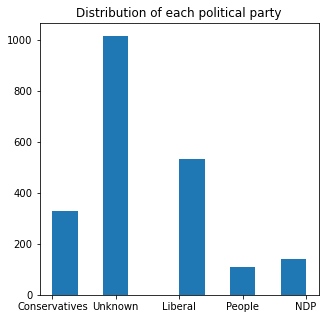

In [40]:
plt.figure(figsize=(5,5))
plt.title('Distribution of each political party')
plt.hist(election_data.Party, bins = 10)
plt.show()

In [41]:
# Visualization of election data using word cloud
election_all_string = election_data.clean_word.apply(lambda x:' '.join(x)).str.cat(sep=' ')

In [42]:
election_all_string=election_all_string.split()
election_all_string=[word for word in election_all_string if word not in ['elxn43','cdnpoli']]

In [43]:
election_all_string=' '.join(election_all_string)

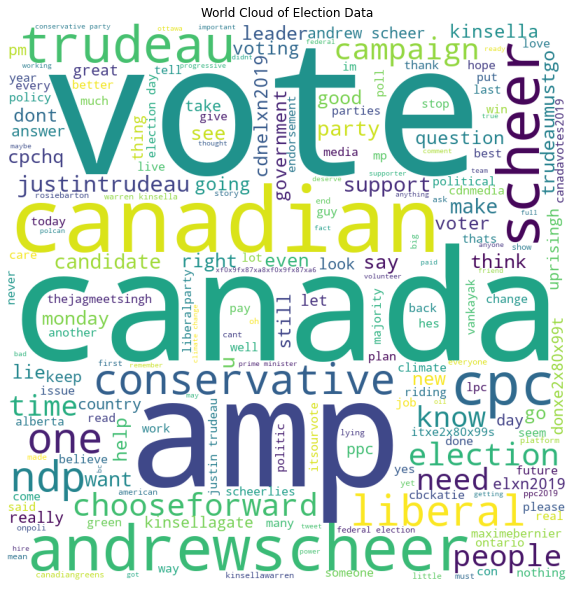

In [44]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', min_font_size = 10).generate(election_all_string)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.title('World Cloud of Election Data')
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## 2.2 Visualization of generic tweets

In [45]:
generic_tweet

,text,label,clean_word
0,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, looking, forward, tab, breeder..."
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[mianusmanjaved, congratulations, pakistan, be..."
2,"RT @PEPalerts: This September, @YESmag is taki...",1,"[pepalerts, september, yesmag, taking, maine, ..."
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[davidgaibis, newly, painted, walls, thanks, m..."
4,RT @CedricFeschotte: Excited to announce: as o...,1,"[cedricfeschotte, excited, announce, july, 201..."
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,"[goddesseso, cant, stop, watching, hermm]"
550387,Poor old Tom Odell doesn't look like he would ...,0,"[poor, old, tom, odell, doesnt, look, like, wo..."
550388,#antsmasher I smashed 7 ants in this awesome ...,1,"[antsmasher, smashed, 7, ants, awesome, gamehj..."
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,"[lizhudston, kymwyllie, evasmiless, meanbok, l..."


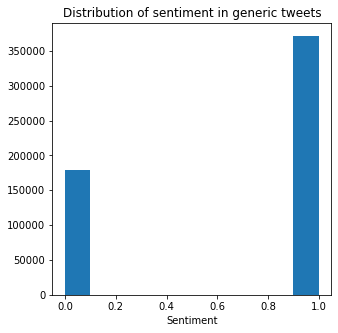

In [96]:
plt.figure(figsize=(5,5))
plt.title('Distribution of sentiment in generic tweets')
plt.xlabel('Sentiment')
plt.hist(generic_tweet.label, bins = 10)
plt.show()

In [47]:
generic_all_string = generic_tweet.clean_word.apply(lambda x:' '.join(x)).str.cat(sep=' ')

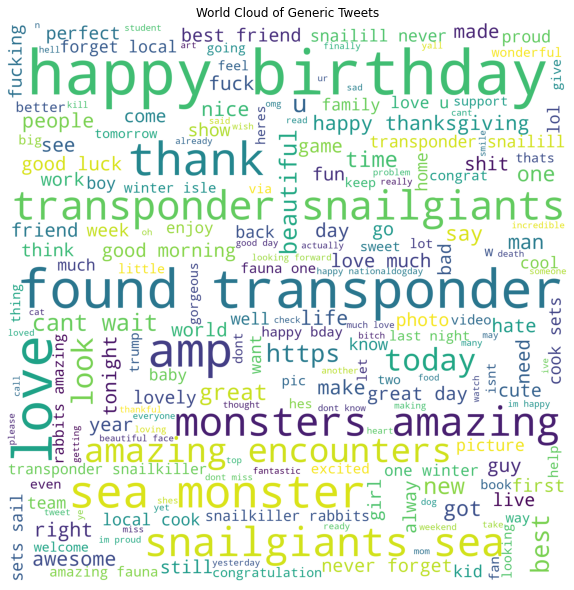

In [48]:
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', min_font_size = 10).generate(generic_all_string)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.title('World Cloud of Generic Tweets')
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## 3.0 Model Preparation

In [49]:
# Convert 'negative' and 'positive' to 0 and 1 
sentiment_dict={
    'negative':0,
    'positive':1
}
election_data['label']=election_data.sentiment.map(sentiment_dict)

# Add a column for clean_text in the election data
election_data['clean_text']=election_data.clean_word.apply(' '.join)

election_data

,sentiment,negative_reason,text,clean_word,Liberal,Conservatives,NDP,Green,People,Party,label,clean_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana...",0,2,0,0,0,Conservatives,0,rosiebarton instead suggestion agree canadian ...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, realspacestation, etobicok...",0,0,0,0,0,Unknown,1,allwomanspacewalk realspacestation etobicokeno...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, next, 4,...",1,0,0,0,0,Liberal,0,brantford going cost 94 billion next 4 years a...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, elxn...",0,0,0,0,0,Unknown,1,canada canadaelection2019 canadavotes elxn43 c...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea...",0,3,3,0,3,Conservatives,0,canada taxpayers sick amp tired hard earned do...
...,...,...,...,...,...,...,...,...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,"[know, good, enough, job, smearing, campaign, ...",0,1,0,0,1,Conservatives,0,know good enough job smearing campaign right a...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,"[missed, comment, deflecting, issue, answer, b...",0,0,0,0,0,Unknown,0,missed comment deflecting issue answer best re...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,"[daily, reminderthejagmeetsingh, endorses, str...",0,0,1,0,0,NDP,1,daily reminderthejagmeetsingh endorses strateg...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,"[yupnot, going, reopen, abortion, debatexf0x9f...",2,0,2,0,2,Liberal,0,yupnot going reopen abortion debatexf0x9fx98x8...


In [50]:
# Add a column for clean_text in the generic tweets
generic_tweet['clean_text']=generic_tweet.clean_word.apply(' '.join)

generic_tweet

,text,label,clean_word,clean_text
0,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, looking, forward, tab, breeder...",josh jenkins looking forward tab breeders crow...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[mianusmanjaved, congratulations, pakistan, be...",mianusmanjaved congratulations pakistan becomi...
2,"RT @PEPalerts: This September, @YESmag is taki...",1,"[pepalerts, september, yesmag, taking, maine, ...",pepalerts september yesmag taking maine mendoz...
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[davidgaibis, newly, painted, walls, thanks, m...",davidgaibis newly painted walls thanks million...
4,RT @CedricFeschotte: Excited to announce: as o...,1,"[cedricfeschotte, excited, announce, july, 201...",cedricfeschotte excited announce july 2017 fes...
...,...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,"[goddesseso, cant, stop, watching, hermm]",goddesseso cant stop watching hermm
550387,Poor old Tom Odell doesn't look like he would ...,0,"[poor, old, tom, odell, doesnt, look, like, wo...",poor old tom odell doesnt look like would know...
550388,#antsmasher I smashed 7 ants in this awesome ...,1,"[antsmasher, smashed, 7, ants, awesome, gamehj...",antsmasher smashed 7 ants awesome gamehjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,"[lizhudston, kymwyllie, evasmiless, meanbok, l...",lizhudston kymwyllie evasmiless meanbok linddy...


In [51]:
X_test_election = election_data.clean_text
y_test_election = election_data.label

## 3.1 Splitting the generic tweets into training and testing data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(generic_tweet.clean_text, generic_tweet.label, 
                                                                test_size=0.3, random_state=42)

## 3.2 Bag of words and tf-idf



In [58]:
## wf for testing and training data with 1000 features
CountVec = CountVectorizer(max_features = 1000)

X_train_wf = CountVec.fit_transform(X_train)
X_test_wf = CountVec.transform(X_test)
election_test_wf = CountVec.transform(X_test_election)

In [54]:
## tf-idf for testing and training data with 1000 features
tfidfVec = TfidfVectorizer(max_features=1000)

X_train_tfidf = tfidfVec.fit_transform(X_train)
X_test_tfidf = tfidfVec.transform(X_test)
election_test_tfidf = tfidfVec.transform(X_test_election)

In [55]:
import warnings
warnings.filterwarnings('ignore')

## 3.3. Model Implementation

## Model 1: Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression().fit(X_train_wf,y_train)
model2 = LogisticRegression().fit(X_train_tfidf,y_train)

fscore_logreg_wf=f1_score(model1.predict(X_test_wf),y_test)
fscore_logreg_tfidf=f1_score(model2.predict(X_test_tfidf),y_test)

print('The logistic regression model with word frequency as features has an f1 score of {}'.format(fscore_logreg_wf))
print('The logistic regression model with tf-idf as features has an f1 score of {}'.format(fscore_logreg_tfidf))

The logistic regression model with word frequency as features has an f1 score of 0.9497781850843717
The logistic regression model with tf-idf as features has an f1 score of 0.9489216696084615


## Model 2: Knn

In [65]:
# Use the rule of thumb: k = square root of n
neighbors=round(X_train_wf.shape[0]**0.5)
neighbors

621

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn_wf = KNeighborsClassifier(n_neighbors=neighbors,algorithm='kd_tree',leaf_size = 1000).fit(X_train_wf,y_train)
knn_tfidf = KNeighborsClassifier(n_neighbors=neighbors,algorithm='kd_tree',leaf_size = 1000).fit(X_train_tfidf,y_train)

fscore_knn_wf=f1_score(knn_wf.predict(X_test_wf),y_test)
fscore_knn_tfidf=f1_score(knn_tfidf.predict(X_test_tfidf),y_test)

print('The Knn model with word frequency as features has an f1 score of {}'.format(fscore_knn_wf))
print('The Knn model with tf-idf as features has an f1 score of {}'.format(fscore_knn_tfidf))

The Knn model with word frequency as features has an f1 score of 0.867739012460638
The Knn model with tf-idf as features has an f1 score of 0.6417147645857678


## Model 3: Multinominal Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
gnb_wf = MultinomialNB().fit(X_train_wf.todense(),y_train)
gnb_tfidf = MultinomialNB().fit(X_train_tfidf.todense(),y_train)

fscore_gnb_wf=f1_score(gnb_wf.predict(X_test_wf.todense()),y_test)
fscore_gnb_tfidf=f1_score(gnb_tfidf.predict(X_test_tfidf.todense()),y_test)

print('The Multinominal Naive Bayes model with word frequency as features has an f1 score of {}'.format(fscore_gnb_wf))
print('The Multinominal Naive Bayes model with tf-idf as features has an f1 score of {}'.format(fscore_gnb_tfidf))

The Multinominal Naive Bayes model with word frequency as features has an f1 score of 0.9271982047793811
The Multinominal Naive Bayes model with tf-idf as features has an f1 score of 0.9227357031136486


## Model 4: SVM (Linear SVC)

In [61]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_wf = make_pipeline(StandardScaler(with_mean=False),LinearSVC()).fit(X_train_wf,y_train)
clf_tfidf=make_pipeline(StandardScaler(with_mean=False),LinearSVC()).fit(X_train_tfidf,y_train)

fscore_clf_wf=f1_score(clf_wf.predict(X_test_wf),y_test)
fscore_clf_tfidf = f1_score(clf_tfidf.predict(X_test_tfidf),y_test)

print('The SVM model with word frequency as features has an f1 score of {}'.format(fscore_clf_wf))
print('The SVM model with tf-idf as features has an f1 score of {}'.format(fscore_clf_tfidf))


The SVM model with word frequency as features has an f1 score of 0.9388094491623613
The SVM model with tf-idf as features has an f1 score of 0.9332953301302063


## Model 5: Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier
tree_wf=DecisionTreeClassifier().fit(X_train_wf,y_train)          
tree_tfidf = DecisionTreeClassifier().fit(X_train_tfidf,y_train)

fscore_tree_wf=f1_score(tree_wf.predict(X_test_wf),y_test)
fscore_tree_tfidf = f1_score(tree_tfidf.predict(X_test_tfidf),y_test)

print('The Decision Tree model with word frequency as features has an f1 score of {}'.format(fscore_tree_wf))
print('The Decision Tree model with tf-idf as features has an f1 score of {}'.format(fscore_tree_tfidf))

The Decision Tree model with word frequency as features has an f1 score of 0.9413526057191077
The Decision Tree model with tf-idf as features has an f1 score of 0.9429033529499709


## Model 6: Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

rfc_wf = RandomForestClassifier().fit(X_train_wf,y_train)
rfc_tfidf=RandomForestClassifier().fit(X_train_tfidf,y_train)
fscore_rfc_wf=f1_score(rfc_wf.predict(X_test_wf),y_test)
fscore_rfc_tfidf=f1_score(rfc_tfidf.predict(X_test_tfidf),y_test)

print('The Random Forest model with word frequency as features has an f1 score of {}'.format(fscore_rfc_wf))
print('The Random Forest model with tf-idf as features has an f1 score of {}'.format(fscore_rfc_tfidf))

The Random Forest model with word frequency as features has an f1 score of 0.9503234645640714
The Random Forest model with tf-idf as features has an f1 score of 0.9526339168351298


## Model 7: XGBoost

In [67]:
import xgboost as xgb

xgb_wf = xgb.XGBClassifier().fit(X_train_wf,y_train)
xgb_tfidf = xgb.XGBClassifier().fit(X_train_tfidf,y_train)

fscore_xgb_wf=f1_score(xgb_wf.predict(X_test_wf),y_test)
fscore_xgb_tfidf=f1_score(xgb_tfidf.predict(X_test_tfidf),y_test)

print('The XGBoost model with word frequency as features has an f1 score of {}'.format(fscore_xgb_wf))
print('The XGBoost model with tf-idf as features has an f1 score of {}'.format(fscore_xgb_tfidf))

[04:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:03:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The XGBoost model with word frequency as features has an f1 score of 0.9336554142013225
The XGBoost model with tf-idf as features has an f1 score of 0.9337837329925581


## 4.0 Election Data

## 4.1 Apply the best model - Random Forest with tf-idf

In [68]:
election_model=RandomForestClassifier().fit(X_train_tfidf,y_train)
election_prediction = election_model.predict(election_test_tfidf)
f1_score(election_data.label,election_prediction)

0.542627345844504

In [69]:
# Create a dataframe to store the predictions
election_pred_df = pd.DataFrame({'Party':election_data.Party,'Sentiment':election_prediction})
election_pred_df

,Party,Sentiment
0,Conservatives,1
1,Unknown,0
2,Liberal,0
3,Unknown,0
4,Conservatives,0
...,...,...
2128,Conservatives,1
2129,Unknown,1
2130,NDP,0
2131,Liberal,0


In [70]:
election_data.label.value_counts()

1    1127
0    1006
Name: label, dtype: int64

In [71]:
election_pred_df.Sentiment.value_counts()

0    1395
1     738
Name: Sentiment, dtype: int64

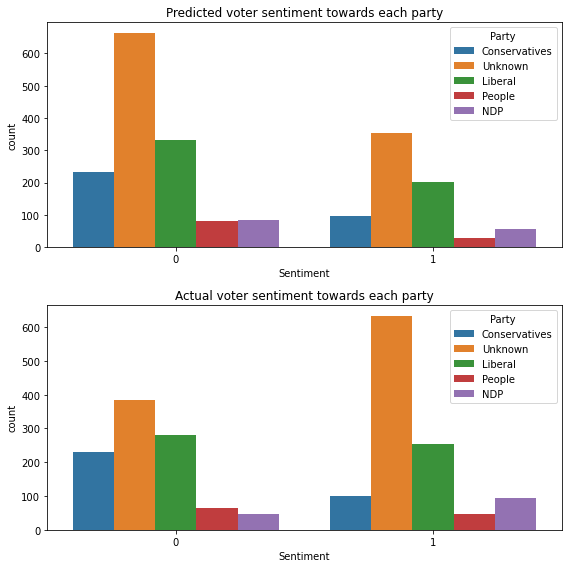

In [72]:
fig, ax =plt.subplots(2,1,figsize=(8,8))
sns.countplot(x='Sentiment',hue='Party',data=election_pred_df,ax=ax[0])
ax[0].title.set_text('Predicted voter sentiment towards each party')

sns.countplot(x='label',hue='Party',data=election_data,ax=ax[1])
ax[1].title.set_text('Actual voter sentiment towards each party')

ax[1].set_xlabel('Sentiment')

fig.tight_layout()

## 4.2 Train 3 models to predict reasons for negative tweets

In [73]:
# Slicing the election data where only negative sentiment data remain.
election_negative = election_data[election_data.sentiment=='negative']
election_negative

,sentiment,negative_reason,text,clean_word,Liberal,Conservatives,NDP,Green,People,Party,label,clean_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana...",0,2,0,0,0,Conservatives,0,rosiebarton instead suggestion agree canadian ...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, next, 4,...",1,0,0,0,0,Liberal,0,brantford going cost 94 billion next 4 years a...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea...",0,3,3,0,3,Conservatives,0,canada taxpayers sick amp tired hard earned do...
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[canadavotes2019, elxn43, cdnpoli, facts, blas...",0,1,0,0,0,Conservatives,0,canadavotes2019 elxn43 cdnpoli facts blastfrom...
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[chooseforward, cdnpoli, elxn43canada, dont, m...",1,0,0,0,0,Liberal,0,chooseforward cdnpoli elxn43canada dont make a...
...,...,...,...,...,...,...,...,...,...,...,...,...
2125,negative,Others,b'You can\xe2\x80\x99t be a supervillain of an...,"[canxe2x80x99t, supervillain, election, failed...",0,0,0,0,0,Unknown,0,canxe2x80x99t supervillain election failed job...
2126,negative,Climate Problem,b'You care about limiting #ClimateChange and a...,"[care, limiting, climatechange, wondering, par...",0,0,0,0,0,Unknown,0,care limiting climatechange wondering party vo...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,"[know, good, enough, job, smearing, campaign, ...",0,1,0,0,1,Conservatives,0,know good enough job smearing campaign right a...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,"[missed, comment, deflecting, issue, answer, b...",0,0,0,0,0,Unknown,0,missed comment deflecting issue answer best re...


In [74]:
election_negative.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

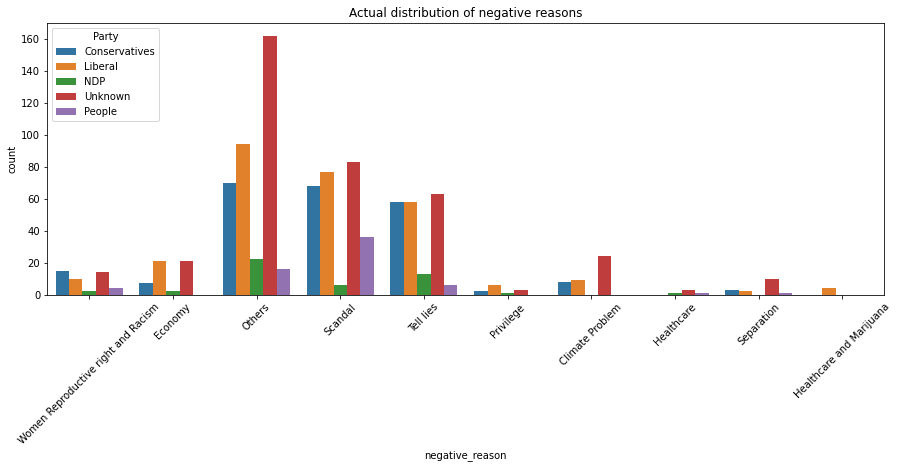

In [92]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
ax=sns.countplot(x= 'negative_reason',hue='Party',data=election_negative)
ax.title.set_text('Actual distribution of negative reasons')

## Word Frequency & TF-idf

In [76]:
# Split training and testing
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(election_negative.clean_text, election_negative.negative_reason, 
                                                                test_size=0.3, random_state=42)

In [77]:
# Convert text to wf
CountVec_neg = CountVectorizer()
X_train_neg_wf = CountVec_neg.fit_transform(X_train_neg)
X_test_neg_wf = CountVec_neg.transform(X_test_neg)

# Convert text to tf-idf
tfidfVec_neg = TfidfVectorizer()
X_train_neg_tfidf = tfidfVec_neg.fit_transform(X_train_neg)
X_test_neg_tfidf = tfidfVec_neg.transform(X_test_neg)


## Word Embedding

In [78]:
# Word Embedding using Spacy
import spacy
nlp = spacy.load('en_core_web_lg')
X_train_df = pd.DataFrame(X_train_neg)
X_test_df = pd.DataFrame(X_test_neg)

In [79]:
xtrain_list = X_train_df.clean_text.apply(lambda text: nlp(text).vector)
X_train_df['vectors'] = xtrain_list
veclist_train=X_train_df['vectors'].values.tolist()

X_train_neg_embed = pd.DataFrame(veclist_train,index=X_train_df.index)
X_train_neg_embed

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
985,-0.077737,0.068613,0.013485,0.067014,-0.059437,0.069127,0.013302,-0.068407,-0.007380,1.016886,...,-0.086219,-0.010179,-0.019732,0.014956,0.055916,-0.070174,-0.002228,0.061759,-0.014762,0.036123
808,-0.113532,0.009988,0.030984,0.006338,0.000741,0.048819,0.038563,-0.094102,-0.000097,1.268408,...,0.158669,0.052826,-0.026767,-0.067384,-0.014595,0.018692,-0.051168,-0.032645,-0.077353,0.109355
1919,-0.103013,0.149750,0.017636,-0.029389,0.083033,-0.104033,0.057963,-0.128622,0.039895,1.987665,...,-0.079650,-0.036625,-0.037557,-0.114389,0.024381,0.000872,-0.060139,-0.106969,-0.043397,0.042606
741,-0.292734,0.239411,-0.083608,-0.147189,-0.033152,-0.096365,-0.050391,-0.103623,-0.039293,1.419686,...,-0.018111,0.033607,-0.019912,-0.141419,0.105598,-0.050276,0.041054,0.020764,0.121210,0.006717
2042,-0.100398,0.080269,-0.145412,0.103277,-0.134091,-0.070829,-0.063566,0.070921,0.086368,1.441758,...,-0.004011,-0.039724,-0.117109,-0.082260,0.077043,0.075283,-0.067694,-0.050935,-0.042036,-0.032920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,-0.035125,0.156264,-0.148315,0.002206,0.000584,0.107225,-0.005868,-0.061127,-0.004136,1.585481,...,-0.042821,0.053849,0.045849,0.050614,0.173415,-0.020384,-0.086151,0.041256,0.088804,-0.002551
493,-0.114094,0.099883,0.024416,0.114219,-0.035939,-0.020177,0.057316,0.076764,0.042068,1.369477,...,-0.009876,-0.001219,-0.068158,0.019416,0.047907,0.026412,-0.074318,-0.077999,-0.101266,0.040892
1787,-0.049443,0.117957,0.178114,-0.004482,0.012267,-0.033611,-0.071903,-0.119556,-0.003969,1.764905,...,-0.092069,-0.060287,0.061767,-0.031042,0.194285,-0.048751,-0.066568,-0.106964,-0.021890,-0.196862
796,-0.107581,-0.022324,-0.030464,0.149773,-0.024501,0.039073,0.036225,-0.074752,0.058261,1.280050,...,-0.002353,0.078183,-0.100488,-0.028910,0.118058,-0.077745,-0.009882,-0.020206,0.202635,-0.015815


In [80]:
xtest_list = X_test_df.clean_text.apply(lambda text: nlp(text).vector)
X_test_df['vectors'] = xtest_list
veclist_test=X_test_df['vectors'].values.tolist()

X_test_neg_embed = pd.DataFrame(veclist_test,index=X_test_df.index)
X_test_neg_embed

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1952,-0.132901,0.097423,0.038111,0.134267,0.151011,-0.075607,0.042496,-0.210676,0.015437,1.492929,...,0.116985,0.040683,-0.012071,0.042957,0.172697,0.019894,-0.071333,-0.122924,0.248146,-0.085360
1181,-0.187734,0.001427,0.195440,-0.041803,0.017647,-0.125154,0.017664,-0.095929,-0.213870,0.016864,...,0.272720,-0.179847,-0.143857,-0.135215,0.038185,0.017860,0.022137,0.116221,-0.255546,-0.089634
1314,-0.085826,0.038464,-0.120196,-0.078059,0.254750,-0.096517,-0.121493,0.121826,0.114605,1.403491,...,-0.147239,-0.114492,0.163609,-0.139706,-0.060382,0.112884,-0.072524,0.015228,-0.117839,-0.002313
935,-0.052733,0.005814,-0.096360,0.012018,0.030908,-0.035805,-0.131106,-0.038846,0.011720,1.297169,...,0.012112,-0.043564,0.005551,-0.111742,0.060860,0.045698,-0.046690,-0.044154,0.098069,0.018262
680,-0.189418,0.048404,-0.144644,-0.143830,0.100811,-0.006428,0.084800,-0.187827,-0.017835,1.283411,...,0.036151,0.011629,-0.157871,-0.020136,0.105812,0.133477,-0.055880,-0.027357,-0.085108,0.145018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,-0.119253,-0.002937,0.006319,0.023993,-0.123273,-0.047682,-0.103480,-0.122053,-0.029305,1.980489,...,-0.107844,0.003714,0.045702,0.023870,0.021214,0.014387,-0.061849,-0.012082,0.019393,0.062568
1974,-0.059089,0.172607,-0.078885,-0.042578,0.067193,-0.005326,0.083943,-0.156811,0.040293,0.886547,...,-0.099440,0.012620,-0.052524,-0.008943,0.048316,0.096716,0.044122,-0.008133,0.062657,0.057521
686,0.062570,-0.001522,-0.069723,0.030317,0.004949,-0.069489,-0.038381,-0.047540,-0.035275,0.531109,...,-0.037898,0.008658,-0.063361,-0.079954,-0.000162,-0.031363,0.009409,0.006378,0.090074,-0.042358
15,-0.138103,0.021019,-0.020991,-0.033965,-0.024631,-0.003943,-0.024771,-0.133674,-0.005065,1.386624,...,-0.104812,0.085478,-0.095625,-0.035475,0.148947,-0.071003,0.014251,0.010425,0.008022,0.029644


## Model 1: Logistic regression for multi-class
- Hyperparameters: C and solver

In [81]:
def LogReg(word_type,X_train_neg,y_train_neg):
    best_params = {}
    best_accuracy = 0

    for solver in ['newton-cg','lbfgs','sag']:
        for penalty in [0.01, 0.05, 0.1, 0.5, 1]:
            model_log = LogisticRegression(multi_class='multinomial',C =penalty,solver=solver).fit(X_train_neg, y_train_neg)
            score_log=accuracy_score(model_log.predict(X_train_neg),y_train_neg)

            if score_log > best_accuracy:
                best_params = {'C':penalty, 'solver':solver}
                best_accuracy=score_log

    print('The Logistic Regressiont model with {}, C = {}, solver={} has the highest accuracy score of {}'.format(word_type, best_params['C'],best_params['solver'],best_accuracy))

In [82]:
LogReg('word frequency',X_train_neg_wf,y_train_neg)
LogReg('td-idf',X_train_neg_tfidf,y_train_neg)
LogReg('word embedding',X_train_neg_embed,y_train_neg)

The Logistic Regressiont model with word frequency, C = 1, solver=sag has the highest accuracy score of 0.9971590909090909
The Logistic Regressiont model with td-idf, C = 1, solver=newton-cg has the highest accuracy score of 0.8224431818181818
The Logistic Regressiont model with word embedding, C = 1, solver=newton-cg has the highest accuracy score of 0.734375


## Model 2: Multinomial Naive Bayes
- Hyperparameters: Alpha

In [83]:
from sklearn.naive_bayes import GaussianNB
def NB(word_type,X_train_neg,y_train_neg):
    best_params = {}
    best_accuracy = 0

    for al in [0, 0.2, 0.5, 0.8, 1]:
        model_NB = MultinomialNB(alpha=al).fit(X_train_neg, y_train_neg)
        score_NB=accuracy_score(model_NB.predict(X_train_neg),y_train_neg)

        if score_NB > best_accuracy:
            best_params = {'alpha':al}
            best_accuracy=score_NB

    print('The Multinomial Naive Bayes model with {}, alpha = {} has the highest accuracy score of {}'.format(word_type,best_params['alpha'],best_accuracy))

In [84]:
NB('word frequency',X_train_neg_wf,y_train_neg)
NB('td-idf',X_train_neg_tfidf,y_train_neg)
# NB('word embedding',X_train_neg_embed,y_train_neg)   
# Word embedding has negative values, cannot pass into Multinomial NB

The Multinomial Naive Bayes model with word frequency, alpha = 0 has the highest accuracy score of 0.9928977272727273
The Multinomial Naive Bayes model with td-idf, alpha = 0 has the highest accuracy score of 0.9957386363636364


## Model 3: Decision Tree
- Hyperparameters: max_features, max_depth, min_samples leafs

In [85]:
def dec_tree(word_type,X_train_neg,y_train_neg):
    best_params = {}
    best_accuracy = 0

    for features in ['sqrt', 'log2']:
        for depth in [10,20,30]:
            for sample_leafs in [1,2,4]:
                model_dt = DecisionTreeClassifier(max_features=features,max_depth=depth,min_samples_leaf=sample_leafs).fit(X_train_neg, y_train_neg)
                score_dt=accuracy_score(model_dt.predict(X_train_neg),y_train_neg)

                if score_dt > best_accuracy:
                    best_params = {'feature':features, 'depth':depth,'leafs':sample_leafs}
                    best_accuracy=score_dt

    print('The decision tree model with {}, max_feature = {}, max_depth={}, min_samples_leaf={} has the highest accuracy score of {}'.format(word_type,best_params['feature'],best_params['depth'],best_params['leafs'],best_accuracy))         

In [86]:
dec_tree('word frequency',X_train_neg_wf,y_train_neg)
dec_tree('td-idf',X_train_neg_tfidf,y_train_neg)
dec_tree('word embedding',X_train_neg_embed,y_train_neg)

The decision tree model with word frequency, max_feature = sqrt, max_depth=30, min_samples_leaf=1 has the highest accuracy score of 0.6136363636363636
The decision tree model with td-idf, max_feature = sqrt, max_depth=30, min_samples_leaf=1 has the highest accuracy score of 0.6065340909090909
The decision tree model with word embedding, max_feature = sqrt, max_depth=20, min_samples_leaf=1 has the highest accuracy score of 0.9985795454545454


## 4.3 Apply the best model on the training set to predict negative reasons
The best training model:  
- Decision Tree model with word embedding, max_feature = sqrt, max_depth=20, min_samples_leaf=1: accuracy score of 0.9985795454545454

In [88]:
model_dt = DecisionTreeClassifier(max_features='sqrt',max_depth=20,min_samples_leaf=1).fit(X_train_neg_embed, y_train_neg)
score_dt=accuracy_score(model_dt.predict(X_test_neg_embed),y_test_neg)
score_dt

0.31125827814569534

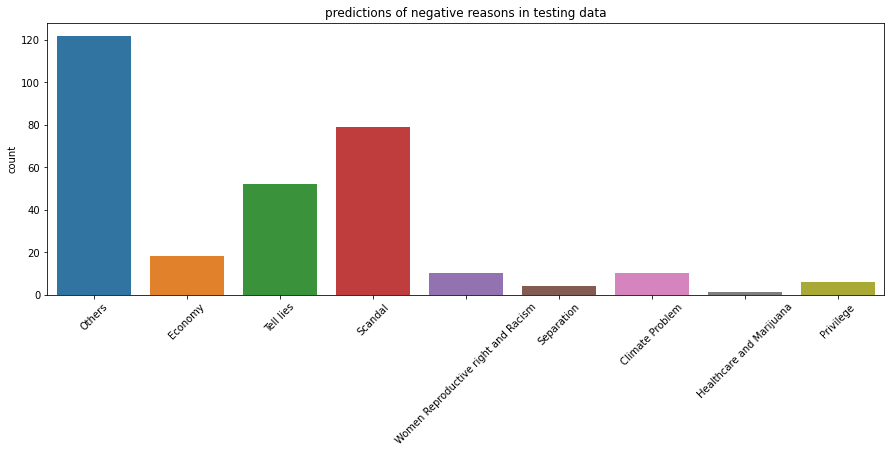

In [112]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
ax=sns.countplot(model_dt.predict(X_test_neg_embed))
ax.title.set_text('predictions of negative reasons in testing data')

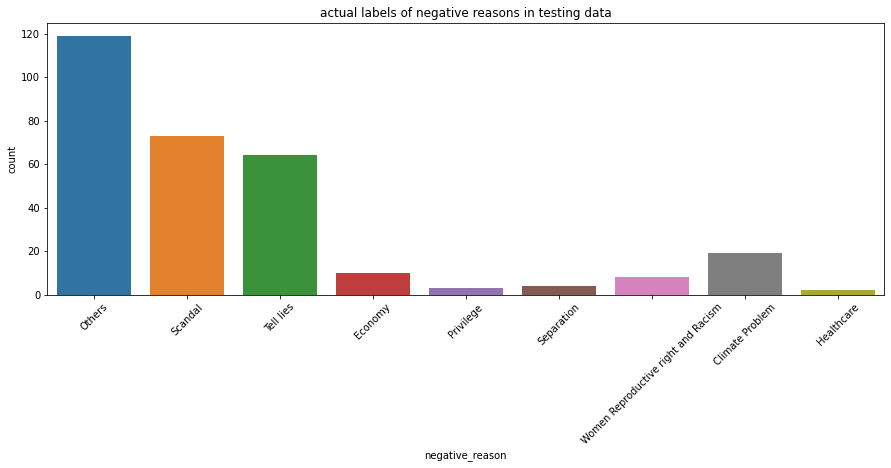

In [111]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
ax=sns.countplot(y_test_neg)
ax.title.set_text('actual labels of negative reasons in testing data')